# Recreating baseline models

>Garcia-Ceja, E., Riegler, M., Jakobsen, P., Tørresen, J., Nordgreen, T., Oedegaard, K.J. and Fasmer, O.B. (2018) Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In: Proceedings of the 9th ACM Multimedia Systems Conference [online]MMSys ’18: 9th ACM Multimedia Systems Conference. Amsterdam Netherlands: ACM, pp. 472–477. Available from: https://dl.acm.org/doi/10.1145/3204949.3208125 [Accessed 2 December 2023].

**Objective**

* Recreating baseline models in the above article

**START @ BASELINE MODEL section**
* import csv file and model
* OR 
* import pickle files

## Preprocessing

* Minimal preprocessing

In [1]:
# import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Extract data from folder

In [8]:

def extract_from_folder(folderpath, downsample=None, save_to_csv=False, output_csv_path=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): folder containing CSV files.
      downsample (int, optional): number of rows to downsample CSVs to. Defaults to None.
      save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
      output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # optional downsample 
                if downsample:
                    df = df.sample(downsample)

                # ID column - this is the filename without the extension
                df['id'] = id

                # 'condition' column
                df['condition'] = subfolder

                # convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)


    try:
        if save_to_csv:
            if output_csv_path:
                df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df
    except OSError:
        print("Error saving to CSV.")


In [9]:
folderpath = '../data/depresjon'


# full ds, no csv
df = extract_from_folder(folderpath)


### Data reduction (as per `scores.csv`)

For the baseline model, I am extracting two versions of the data: 

* **garcia_full_scoreNum** - dataframe reduced by `scores.csv` and full days (1440 rows)
* **garcia_original_scoreNum** - dataframe reduced by `scores.csv'


In [19]:
import pandas as pd

def preprocess_full_days(df, save_to_csv=False, output_csv_path=None, print_info=True):
    """
    Extracts full days from a dataframe.

    Args::
    df (DataFrame): input df.
    save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
    output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
    print_info (bool, optional): print info about the df. defaults to True.

    Returns:
    DataFrame: df containing only full days (1440 rows per day).

    """
    

    # group by id and date, count rows, and filter where count equals 1440
    full_days_df = df.groupby(['id', 'date']).filter(lambda x: len(x) == 1440)

    # set index to timestamp
    #full_days_df.set_index(['timestamp'], inplace=True)
    
    if print_info:
        # print id and date combinations that don't have 1440 rows
        not_full_days = df.groupby(['id', 'date']).size().reset_index(name='count').query('count != 1440')
        print("\nid and date combinations that don't have 1440 rows and have been removed:\n")
        print(not_full_days)

        # print info
        print("\nfull_days_df info:\n")
        print(full_days_df.info())

        #print full days per id
        print("\nfull days per id:\n")
        print(full_days_df.groupby('id').size()/1440)

        # print min number of days
        print("\nmin number of days per id:\n")
        print(full_days_df.groupby('id').size().min()/1440)
        

    try:
        if save_to_csv:
            if output_csv_path:
                full_days_df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return full_days_df
    except OSError:
        print("Error saving to CSV.")

    return full_days_df

def extract_days_per_scores(df, scores_csv_path='..\data\depresjon\scores.csv', save_to_csv=True, output_csv_path=None):
    """
    Extract the number of days per ID from the 'scores' data.

    Args:
        df (pd.DataFrame): df containing the 'id' column.
        scores_csv_path (str, optional): path to the 'scores' CSV file. Defaults to '..\data\depresjon\scores.csv'.
        save_to_csv (bool, optional): save the updated df to a CSV file? Defaults to True.
        output_csv_path (str, optional): csv filepath. Required if save_to_csv is True.
        

    Returns:
        pd.DataFrame: df with the specified number of days per ID based on 'scores'.
    """
    # scores from the CSV file
    scores_df = pd.read_csv(scores_csv_path)

    # merge scores with the df based on the 'id' column
    merged_df = pd.merge(df, scores_df, left_on='id', right_on='number', how='left')

    # filter rows to keep the specified number of days
    df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)

    # drop cols number, days, gender, age, afftype, melanch, inpatient, edu, marriage, work, madrs1, madrs2
    cols = ['number', 'number', 'days', 'gender', 'age', 'afftype', 'melanch', 'inpatient', 'edu', 'marriage', 'work', 'madrs1', 'madrs2']
    df_filtered.drop(cols, axis=1, inplace=True)
    

    # save to CSV
    if save_to_csv:
        if output_csv_path:
            df_filtered.to_csv(output_csv_path, index=False)
            print(f"\n\ndf saved to {output_csv_path}")
        else:
            print("Error: Please provide an output CSV path.")

    return df_filtered



In [20]:
scores_csv_path = '../data/depresjon/scores.csv'
garcia_full_scoreNum = '../data/petter/baseline-garcia-full-scoreNum.csv'
garcia_original_scoreNum = '../data/petter/baseline-garcia-original-scoreNum.csv'

# full days - 1440 rows per day
garcia_full = preprocess_full_days(df)
# scores days - number of days per ID based on 'scores'
garcia_full_score = extract_days_per_scores(garcia_full, scores_csv_path, save_to_csv=True, output_csv_path=garcia_full_scoreNum)
# scores days - number of days per ID based on 'scores'
garcia_score_original = extract_days_per_scores(df, scores_csv_path, save_to_csv=True, output_csv_path=garcia_original_scoreNum)



id and date combinations that don't have 1440 rows and have been removed:

                id       date  count
0      condition_1 2003-05-07    720
16     condition_1 2003-05-23    924
17    condition_10 2004-08-31    900
32    condition_10 2004-09-15    495
33    condition_11 2004-09-28    870
...            ...        ...    ...
1101     control_7 2003-04-23    610
1102     control_8 2003-11-04    900
1122     control_8 2003-11-24    658
1123     control_9 2003-11-11    900
1143     control_9 2003-12-01    778

[115 rows x 3 columns]

full_days_df info:

<class 'pandas.core.frame.DataFrame'>
Index: 1481760 entries, 540 to 1570797
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1481760 non-null  datetime64[ns]
 1   date       1481760 non-null  datetime64[ns]
 2   activity   1481760 non-null  int64         
 3   id         1481760 non-null  object        
 4   label      1481760 non-null

C:\Users\zoona\AppData\Local\Temp\ipykernel_9588\328979493.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)




df saved to ../data/petter/baseline-garcia-full-scoreNum.csv


C:\Users\zoona\AppData\Local\Temp\ipykernel_9588\328979493.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)




df saved to ../data/petter/baseline-garcia-original-scoreNum.csv


In [2]:
import pandas as pd

# Load data from csv
garcia_full_scoreNum = '../data/petter/baseline-garcia-full-scoreNum.csv'
garcia_original_scoreNum = '../data/petter/baseline-garcia-original-scoreNum.csv'

# set date, timestamp as datetime
garcia_full_scoreNum = pd.read_csv(garcia_full_scoreNum, parse_dates=['date', 'timestamp'])
garcia_original_scoreNum = pd.read_csv(garcia_original_scoreNum, parse_dates=['date', 'timestamp'])


In [31]:
# print min, max of timestamp for condition_1
print(garcia_original_scoreNum[garcia_original_scoreNum['id'] == 'condition_1']['timestamp'].min())
print(garcia_original_scoreNum[garcia_original_scoreNum['id'] == 'condition_1']['timestamp'].max())

# print num rows by id, date
garcia_original_scoreNum.groupby(['id', 'date']).size()



2003-05-07 12:00:00
2003-05-18 11:59:00


id           date      
condition_1  2003-05-07     720
             2003-05-08    1440
             2003-05-09    1440
             2003-05-10    1440
             2003-05-11    1440
                           ... 
control_9    2003-11-20    1440
             2003-11-21    1440
             2003-11-22    1440
             2003-11-23    1440
             2003-11-24     540
Length: 748, dtype: int64

In [32]:
# print head
#print(garcia.head())

# print shape
#print(garcia.shape)

# print average, min, max, sd days for label 0
print(f"Average number of days for control (label=0): {garcia_original_scoreNum[garcia_original_scoreNum['label'] == 0].groupby('id').size().mean()/1440:.2f}")
print(f"SD number of days for control (label=0): {garcia_original_scoreNum[garcia_original_scoreNum['label'] == 0].groupby('id').size().std()/1440:.2f}")
print(f"Min number of days for control (label=0): {garcia_original_scoreNum[garcia_original_scoreNum['label'] == 0].groupby('id').size().min()/1440:.2f}")
print(f"Max number of days for control (label=0): {garcia_original_scoreNum[garcia_original_scoreNum['label'] == 0].groupby('id').size().max()/1440:.2f}")


print("\n")

# print average, min, max, sd days for label 0
print(f"Average number of days for condition (label=1): {garcia_original_scoreNum[garcia_original_scoreNum['label'] == 1].groupby('id').size().mean()/1440:.2f}")
print(f"SD number of days for condition (label=1): {garcia_original_scoreNum[garcia_original_scoreNum['label'] == 1].groupby('id').size().std()/1440:.2f}")
print(f"Min number of days for condition (label=1): {garcia_original_scoreNum[garcia_original_scoreNum['label'] == 1].groupby('id').size().min()/1440:.2f}")
print(f"Max number of days for condition (label=1): {garcia_original_scoreNum[garcia_original_scoreNum['label'] == 1].groupby('id').size().max()/1440:.2f}")



Average number of days for control (label=0): 12.56
SD number of days for control (label=0): 2.31
Min number of days for control (label=0): 8.00
Max number of days for control (label=0): 20.00


Average number of days for condition (label=1): 12.65
SD number of days for condition (label=1): 2.77
Min number of days for condition (label=1): 5.00
Max number of days for condition (label=1): 18.00


C:\Users\zoona\AppData\Local\Temp\ipykernel_9588\3077747514.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([int(i) for i in plt.gca().get_yticks()/1440])


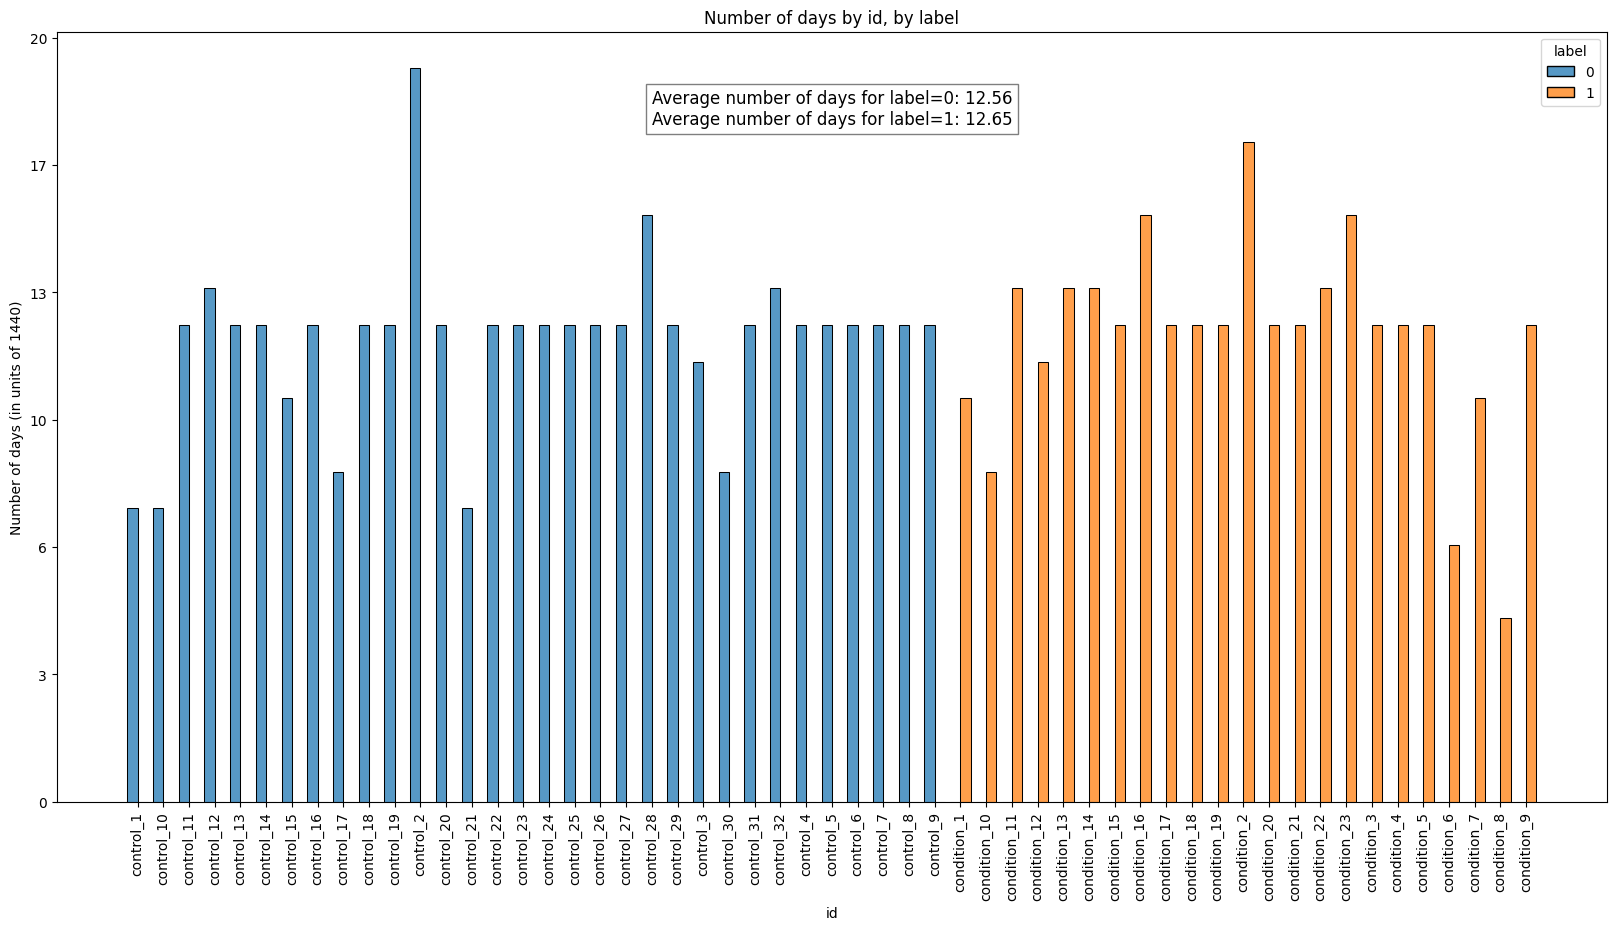

In [33]:

# plot histogram of days by id, by label
plt.figure(figsize=(20,10))
sns.histplot(data=garcia_original_scoreNum, x='id', hue='label', multiple='dodge', shrink=.8)
plt.title('Number of days by id, by label')
plt.xticks(rotation=90)
plt.xlabel('id')
plt.ylabel('Number of days (in units of 1440)')
plt.gca().set_yticklabels([int(i) for i in plt.gca().get_yticks()/1440])
# add text box with average number of days for each label
plt.text(0.5, 0.9, f"Average number of days for label=0: {garcia_original_scoreNum[garcia_original_scoreNum['label'] == 0].groupby('id').size().mean()/1440:.2f}\nAverage number of days for label=1: {garcia_original_scoreNum[garcia_original_scoreNum['label'] == 1].groupby('id').size().mean()/1440:.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.show()



### Heatmaps

#### Raw activity heatmap

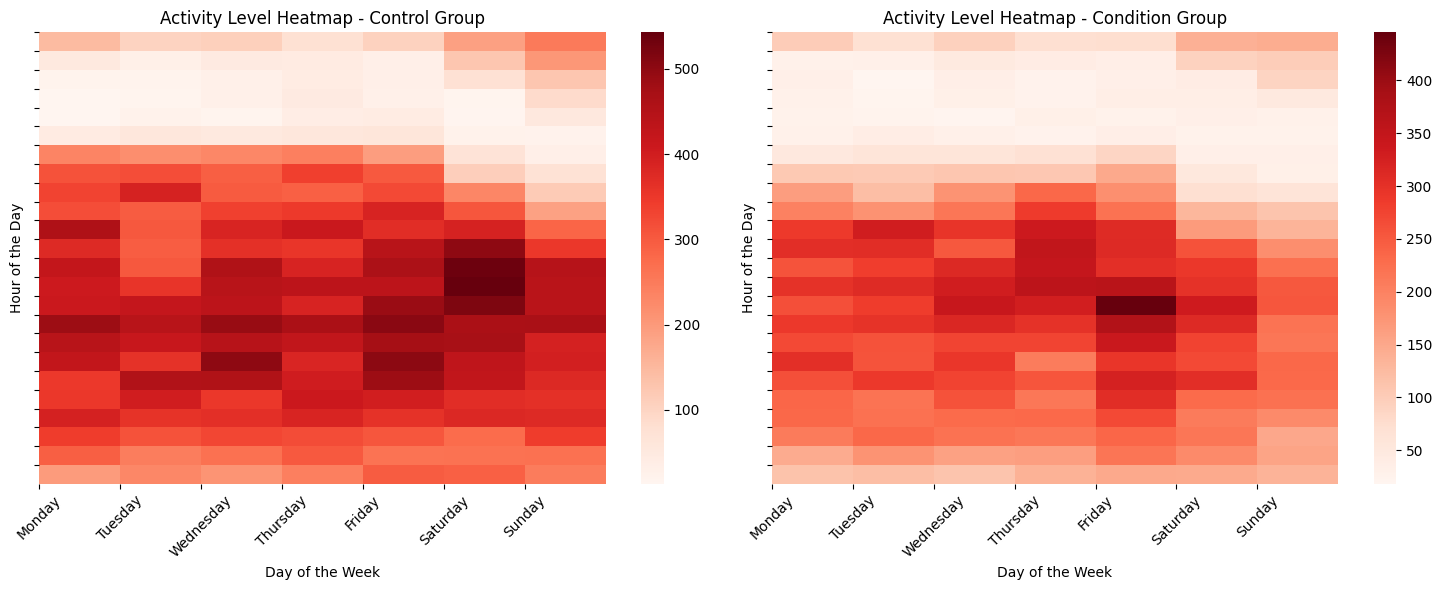

In [34]:
import seaborn as sns
import calendar
import matplotlib.pyplot as plt

# normalise the activity column
scaler = StandardScaler()
garcia_original_scoreNum['activity_norm'] = scaler.fit_transform(garcia_original_scoreNum[['activity']])

# extract day of the week (0 = Monday, 6 = Sunday) and hour of the day (0 to 23)
garcia_original_scoreNum['day_of_week'] = garcia_original_scoreNum['timestamp'].dt.dayofweek
garcia_original_scoreNum['hour_of_day'] = garcia_original_scoreNum['timestamp'].dt.hour

# split df by label 
control = garcia_original_scoreNum[garcia_original_scoreNum['label'] == 0]
condition = garcia_original_scoreNum[garcia_original_scoreNum['label'] == 1]

# pivot table to reshape the data for the heatmap
control_hm = control.pivot_table(index='hour_of_day', columns='day_of_week', values='activity', aggfunc='mean')
condition_hm = condition.pivot_table(index='hour_of_day', columns='day_of_week', values='activity', aggfunc='mean')

# pivot table to reshape the data for the heatmap - normalised
control_hm_norm = control.pivot_table(index='hour_of_day', columns='day_of_week', values='activity_norm', aggfunc='mean')
condition_hm_norm = condition.pivot_table(index='hour_of_day', columns='day_of_week', values='activity_norm', aggfunc='mean')

# plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# control heatmap
sns.heatmap(control_hm, cmap='Reds', annot=False, fmt='.2f', cbar=True, ax=axs[0])
axs[0].set_xlabel('Day of the Week')
axs[0].set_ylabel('Hour of the Day')
axs[0].set_title('Activity Level Heatmap - Control Group')
axs[0].set_yticks(range(24))
axs[0].set_xticks(range(7))
axs[0].set_xticklabels(calendar.day_name, rotation=45)

# condition heatmap
sns.heatmap(condition_hm, cmap='Reds', annot=False, fmt='.2f', cbar=True, ax=axs[1])
axs[1].set_xlabel('Day of the Week')
axs[1].set_ylabel('Hour of the Day')
axs[1].set_title('Activity Level Heatmap - Condition Group')
axs[1].set_yticks(range(24))
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(calendar.day_name, rotation=45)

plt.tight_layout()
plt.show()


#### Heatmap with Normalised Activity

(Garcia-Ceja et al., 2018) produced heatmaps with normalised data.

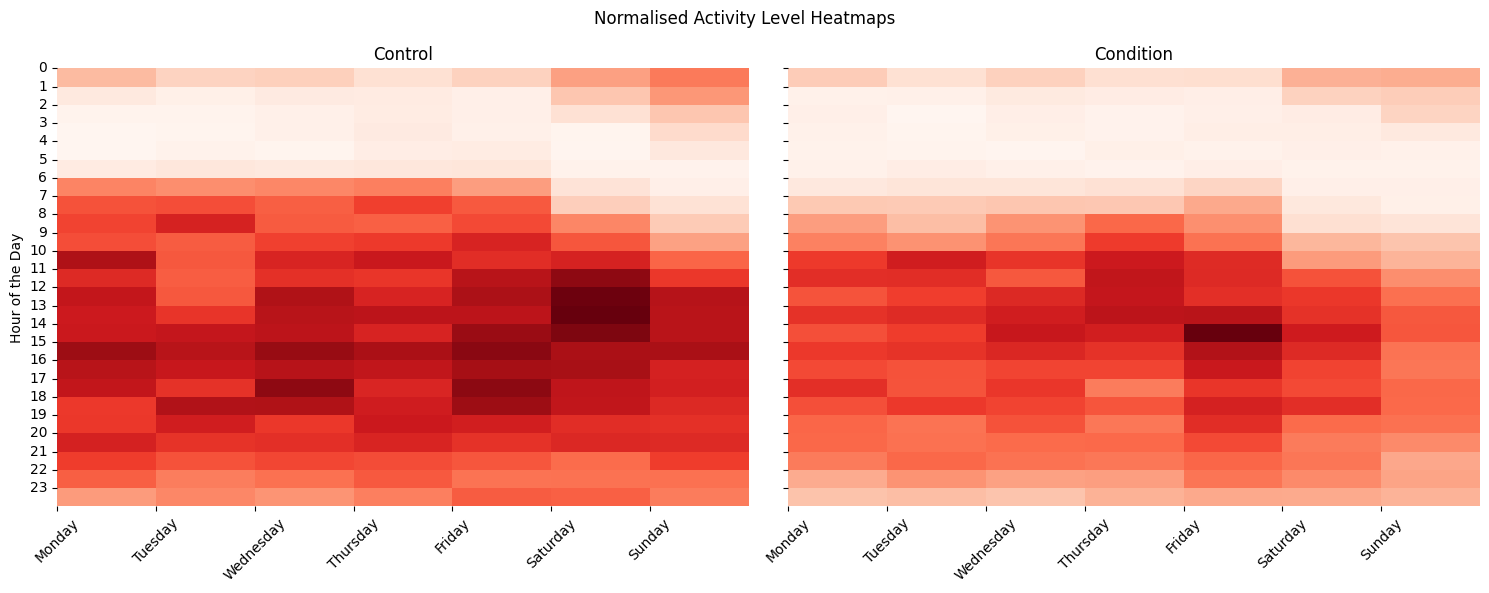

In [36]:
# plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# control heatmap
sns.heatmap(control_hm_norm, cmap='Reds', annot=False, fmt='.2f', cbar=False, ax=axs[0])
#axs[0].set_xlabel('Day of the Week')
axs[0].set_xlabel('')
axs[0].set_ylabel('Hour of the Day')
axs[0].set_title('Control')
axs[0].set_yticks(range(0, 24))
axs[0].set_yticklabels(range(0, 24), rotation=0)  
axs[0].set_xticks(range(7))
axs[0].set_xticklabels(calendar.day_name, rotation=45)

# condition heatmap
sns.heatmap(condition_hm_norm, cmap='Reds', annot=False, fmt='.2f', cbar=False, ax=axs[1])
#axs[1].set_xlabel('Day of the Week')
axs[1].set_xlabel('')
#axs[1].set_ylabel('Hour of the Day')
axs[1].set_ylabel('') 
axs[1].set_title('Condition')
axs[1].set_yticks(range(0, 24))
#axs[1].set_yticklabels(range(0, 24), rotation=0)
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(calendar.day_name, rotation=45)

# add shared title
plt.suptitle('Normalised Activity Level Heatmaps')

plt.tight_layout()
plt.show()

## Baseline Performance

* Nearest Neighbors
* Linear kernel Support Vector Machine (SVM)
* Radial Basis Function kernel (RBF) SVM
* Gaussian Process
* Decision Tree
* Random Forest
* Neural Network
* AdaBoost
* Naive Bayes
* Quadratic Discriminant Analysis (QDA)
* ZeroR

### Version 1: Original 

In [3]:
import pandas as pd
# load data from csv
garcia_full_scoreNum = pd.read_csv('../data/petter/baseline-garcia-full-scoreNum.csv',  parse_dates=['date', 'timestamp'])
garcia_original_scoreNum = pd.read_csv('../data/petter/baseline-garcia-original-scoreNum.csv',  parse_dates=['date', 'timestamp'])

In [4]:
# print head
print(garcia_full_scoreNum.head())

            timestamp       date  activity         id  label
0 2003-03-19 00:00:00 2003-03-19         0  control_1      0
1 2003-03-19 00:01:00 2003-03-19         0  control_1      0
2 2003-03-19 00:02:00 2003-03-19         0  control_1      0
3 2003-03-19 00:03:00 2003-03-19         0  control_1      0
4 2003-03-19 00:04:00 2003-03-19       175  control_1      0


#### Train / Test Split

**Do not use the below - instead use the feature vector creation (next section)**

import pandas as pd
from sklearn.model_selection import train_test_split


# extract relevant features from timestamp
# garcia['day_of_week'] = garcia['timestamp'].dt.dayofweek
# garcia['hour_of_day'] = garcia['timestamp'].dt.hour

# drop unnecessary columns
#X = garcia_original_scoreNum.drop(['timestamp','label', 'date', 'id'], axis=1)
#y = garcia_original_scoreNum['label']

# split the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  set the timestamp as the index:
# X_train.set_index('timestamp', inplace=True)
# X_test.set_index('timestamp', inplace=True)


In [4]:
print(garcia_original_scoreNum.head())

            timestamp       date  activity         id  label
0 2003-03-18 15:00:00 2003-03-18        60  control_1      0
1 2003-03-18 15:01:00 2003-03-18         0  control_1      0
2 2003-03-18 15:02:00 2003-03-18       264  control_1      0
3 2003-03-18 15:03:00 2003-03-18       662  control_1      0
4 2003-03-18 15:04:00 2003-03-18       293  control_1      0


**Feature vectors** by `id` so that predictions are on the person level, not the timestamp (row minute).

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# dictionaries to store feature vectors and labels
feature_vectors_train = {}
feature_vectors_test = {}
labels_train = {}
labels_test = {}

# extract relevant columns (activity and id)
for unique_id in garcia_original_scoreNum['id'].unique():
    subset = garcia_original_scoreNum[garcia_original_scoreNum['id'] == unique_id]
    feature_vectors_train[unique_id] = subset['activity'].values
    labels_train[unique_id] = subset['label'].values[0]  # assuming each id has a single label

# length of the longest feature vector
max_length = max(len(vector) for vector in feature_vectors_train.values())

# pad the feature vectors with zeros to match the length of the longest vector
for unique_id, vector in feature_vectors_train.items():
    padded_vector = np.pad(vector, (0, max_length - len(vector)), mode='constant')
    feature_vectors_train[unique_id] = padded_vector

# split the feature vectors and labels into train and test sets
X_train_array, X_test_array, y_train_array, y_test_array = train_test_split(
    list(feature_vectors_train.values()), list(labels_train.values()), test_size=0.2, random_state=42)

# convert feature vectors and labels to NumPy arrays
X_train_array_np = np.array([np.array(x) for x in X_train_array])
X_test_array_np = np.array([np.array(x) for x in X_test_array])
y_train_array_np = np.array(y_train_array)
y_test_array_np = np.array(y_test_array)

# convert labels to pandas Series
y_train_series = pd.Series(y_train_array_np)
y_test_series = pd.Series(y_test_array_np)


In [6]:
# shape of the arrays
print(X_train_array_np.shape)
print(X_test_array_np.shape)
print(y_train_series.shape)
print(y_test_series.shape)


(44, 28800)
(11, 28800)
(44,)
(11,)


#### Import Libraries

In [7]:
import time

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


#### Functions


In [8]:
def evaluate_models(models, X_train, y_train, X_test, y_test, print_results=True):
    """
    Evaluate the performance of different models on a given dataset.

    Args:
    - models (list): list of tuples containing the name and model object.
    - X_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - X_test (array-like): Test data features.
    - y_test (array-like): Test data labels.

    Returns:
    - results (list): A list of dictionaries containing the evaluation results for each model.
    """
    results = []

    for name, model in models:
        start_time = time.time()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        end_time = time.time()
        elapsed_time = end_time - start_time

        # metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)

        # ROC AUC score
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # keep probabilities for the positive class only
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except AttributeError:
            #  ZeroR doesn't have predict_proba method
            roc_auc = None

        if print_results:
            print(f'{name}:')
            print(f'Time taken: {elapsed_time} seconds')
            print(f'Accuracy: {accuracy}')
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'F1 Score: {f1}')
            print(f'Matthews Correlation Coefficient: {mcc}')
            print(f'Confusion Matrix: {cm}')
            print(f'Classification Report: {cr}')
            print(f'ROC AUC: {roc_auc}')
            print('\n\n')

        results.append({
            'name': name,
            'time': elapsed_time,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'confusion_matrix': cm,
            'classification_report': cr,
            'roc_auc': roc_auc

        })

    return results


In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix, classification_report
import time

def evaluate_models_array(models, X_train, y_train, X_test, y_test, print_results=True):
    results = []

    for name, model in models:
        start_time = time.time()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        end_time = time.time()
        elapsed_time = end_time - start_time

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)

        # ROC AUC score
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # Keep probabilities for the positive class only
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except AttributeError:
            # ZeroR doesn't have predict_proba method
            roc_auc = None

        if print_results:
            print(f'{name}:')
            print(f'Time taken: {elapsed_time} seconds')
            print(f'Accuracy: {accuracy}')
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'F1 Score: {f1}')
            print(f'Matthews Correlation Coefficient: {mcc}')
            print(f'Confusion Matrix:\n{cm}')
            print(f'Classification Report:\n{cr}')
            print(f'ROC AUC: {roc_auc}')
            print('\n\n')

        results.append({
            'name': name,
            'time': elapsed_time,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'confusion_matrix': cm,
            'classification_report': cr,
            'roc_auc': roc_auc
        })

    return results

# Example usage:
# models = [(model1, 'Model 1'), (model2, 'Model 2')]
# results = evaluate(models, X_train_array_np, y_train_array, X_test_array_np, y_test_array)


#### Model selection

I have taken the models from the article and added a few additional models for comparison.  

`ZeroR` (Zero Rule) is a simple baseline model which predicts the most frequent class (label).  It has been created as a class below, for inclusion.  

In [10]:
# ZeroR 
class ZeroRClassifier:
    def fit(self, X, y):
        self.majority_class = y.value_counts().idxmax()
    def predict(self, X):
        return [self.majority_class] * len(X)

**Model sets**

In [11]:
models = [
    ('ZeroR', ZeroRClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Linear SVM', LinearSVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

In [12]:
# these have NOT been run yet - they are very slow!
models_slow = [
    ('SVM', SVC(kernel='rbf')),
    ('SVM', SVC(kernel='linear')),
    ('Gaussian Process', GaussianProcessClassifier())
]

#### Modelling

Models using Feature vectors

In [12]:
# results
results_models = evaluate_models_array(models, X_train_array, y_train_series, X_test_array, y_test_series, print_results=True)

c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Use

ZeroR:
Time taken: 0.002698659896850586 seconds
Accuracy: 0.5454545454545454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Matthews Correlation Coefficient: 0.0
Confusion Matrix:
[[6 0]
 [5 0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       0.00      0.00      0.00         5

    accuracy                           0.55        11
   macro avg       0.27      0.50      0.35        11
weighted avg       0.30      0.55      0.39        11

ROC AUC: None



Random Forest:
Time taken: 0.15041851997375488 seconds
Accuracy: 0.5454545454545454
Precision: 0.5
Recall: 0.4
F1 Score: 0.4444444444444444
Matthews Correlation Coefficient: 0.06900655593423542
Confusion Matrix:
[[4 2]
 [3 2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.50      0.40      0.44         5

    accuracy                  

c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Use

Neural Network:
Time taken: 1.6711328029632568 seconds
Accuracy: 0.5454545454545454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Matthews Correlation Coefficient: 0.0
Confusion Matrix:
[[6 0]
 [5 0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       0.00      0.00      0.00         5

    accuracy                           0.55        11
   macro avg       0.27      0.50      0.35        11
weighted avg       0.30      0.55      0.39        11

ROC AUC: 0.33333333333333337



XGBoost:
Time taken: 1.020531415939331 seconds
Accuracy: 0.8181818181818182
Precision: 1.0
Recall: 0.6
F1 Score: 0.75
Matthews Correlation Coefficient: 0.6708203932499369
Confusion Matrix:
[[6 0]
 [2 3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.60      0.75         5

    accuracy                   

c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost:
Time taken: 3.136207342147827 seconds
Accuracy: 0.6363636363636364
Precision: 0.6666666666666666
Recall: 0.4
F1 Score: 0.5
Matthews Correlation Coefficient: 0.2608745973749754
Confusion Matrix:
[[5 1]
 [3 2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.67      0.40      0.50         5

    accuracy                           0.64        11
   macro avg       0.65      0.62      0.61        11
weighted avg       0.64      0.64      0.62        11

ROC AUC: 0.6000000000000001



QDA:
Time taken: 0.08375334739685059 seconds
Accuracy: 0.7272727272727273
Precision: 0.75
Recall: 0.6
F1 Score: 0.6666666666666666
Matthews Correlation Coefficient: 0.4485426135725303
Confusion Matrix:
[[5 1]
 [2 3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.75      0.60      0.67        

c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Gradient Boosting:
Time taken: 10.87244176864624 seconds
Accuracy: 0.36363636363636365
Precision: 0.3333333333333333
Recall: 0.4
F1 Score: 0.36363636363636365
Matthews Correlation Coefficient: -0.26666666666666666
Confusion Matrix:
[[2 4]
 [3 2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.33      0.40      0.36         5

    accuracy                           0.36        11
   macro avg       0.37      0.37      0.36        11
weighted avg       0.37      0.36      0.36        11

ROC AUC: 0.4666666666666667





#### Save pickle file

In [13]:
import pickle

# save results to a file
with open('models_results.pkl', 'wb') as file:
    pickle.dump(results_models, file)

# load results from the file
#with open('model_results.pkl', 'rb') as file:
#    loaded_results = pickle.load(file)


In [14]:
# results to dataframe
results_df = pd.DataFrame(results_models)
#print(df_results.info())

# for each model, print cols 0:7
#print(df_results.iloc[:, 0:7])

#print(df_results.info())

In [16]:
# print the confusion matrix for each model
for i, cm in enumerate(results_df['confusion_matrix']):
    print(f"Model: {results_df['name'][i]}")
    print(cm)
    print("\n\n")


Model: ZeroR
[[6 0]
 [5 0]]



Model: Random Forest
[[4 2]
 [3 2]]



Model: Linear SVM
[[4 2]
 [4 1]]



Model: Decision Tree
[[3 3]
 [3 2]]



Model: Logistic Regression
[[5 1]
 [5 0]]



Model: KNN
[[2 4]
 [2 3]]



Model: Naive Bayes
[[6 0]
 [4 1]]



Model: Neural Network
[[6 0]
 [5 0]]



Model: XGBoost
[[6 0]
 [2 3]]



Model: LightGBM
[[6 0]
 [2 3]]



Model: AdaBoost
[[5 1]
 [3 2]]



Model: QDA
[[5 1]
 [2 3]]



Model: Gradient Boosting
[[2 4]
 [3 2]]





#### Top Three models in each metric

In [16]:
# print top 3 of each metric
for column_label in results_df.columns[1:7]:
    print(column_label)
    print(results_df.sort_values(by=column_label, ascending=False).head(3)[['name', column_label]])
    print('\n\n')

time
                 name       time
12  Gradient Boosting  13.250413
10           AdaBoost   3.285083
7      Neural Network   3.000310



accuracy
        name  accuracy
8    XGBoost  0.818182
9   LightGBM  0.818182
11       QDA  0.727273



precision
          name  precision
6  Naive Bayes        1.0
8      XGBoost        1.0
9     LightGBM        1.0



recall
             name  recall
7  Neural Network     1.0
5             KNN     0.6
8         XGBoost     0.6



f1
        name        f1
8    XGBoost  0.750000
9   LightGBM  0.750000
11       QDA  0.666667



mcc
        name       mcc
8    XGBoost  0.670820
9   LightGBM  0.670820
11       QDA  0.448543





#### Classification report

In [17]:
# print classification report for eaach model 
for i in range(0, len(results_df)):
    print(results_df['name'][i])
    print(results_df['classification_report'][i])
    print('\n\n')


ZeroR
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       0.00      0.00      0.00         5

    accuracy                           0.55        11
   macro avg       0.27      0.50      0.35        11
weighted avg       0.30      0.55      0.39        11




Random Forest
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.33      0.20      0.25         5

    accuracy                           0.45        11
   macro avg       0.42      0.43      0.41        11
weighted avg       0.42      0.45      0.43        11




Linear SVM
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.33      0.20      0.25         5

    accuracy                           0.45        11
   macro avg       0.42      0.43      0.41        11
weighted avg       0.42      0.45    

#### Plot metrics

C:\Users\zoona\AppData\Local\Temp\ipykernel_17704\3203229096.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_sorted['name'], rotation=90)  # set x-tick labels to the names in the sorted df
C:\Users\zoona\AppData\Local\Temp\ipykernel_17704\3203229096.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_sorted['name'], rotation=90)  # set x-tick labels to the names in the sorted df
C:\Users\zoona\AppData\Local\Temp\ipykernel_17704\3203229096.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_sorted['name'], rotation=90)  # set x-tick labels to the names in the sorted df
C:\Users\zoona\AppData\Local\Temp\ipykernel_17704\3203229096.py:17: UserWarning: set_ticklabels() sh

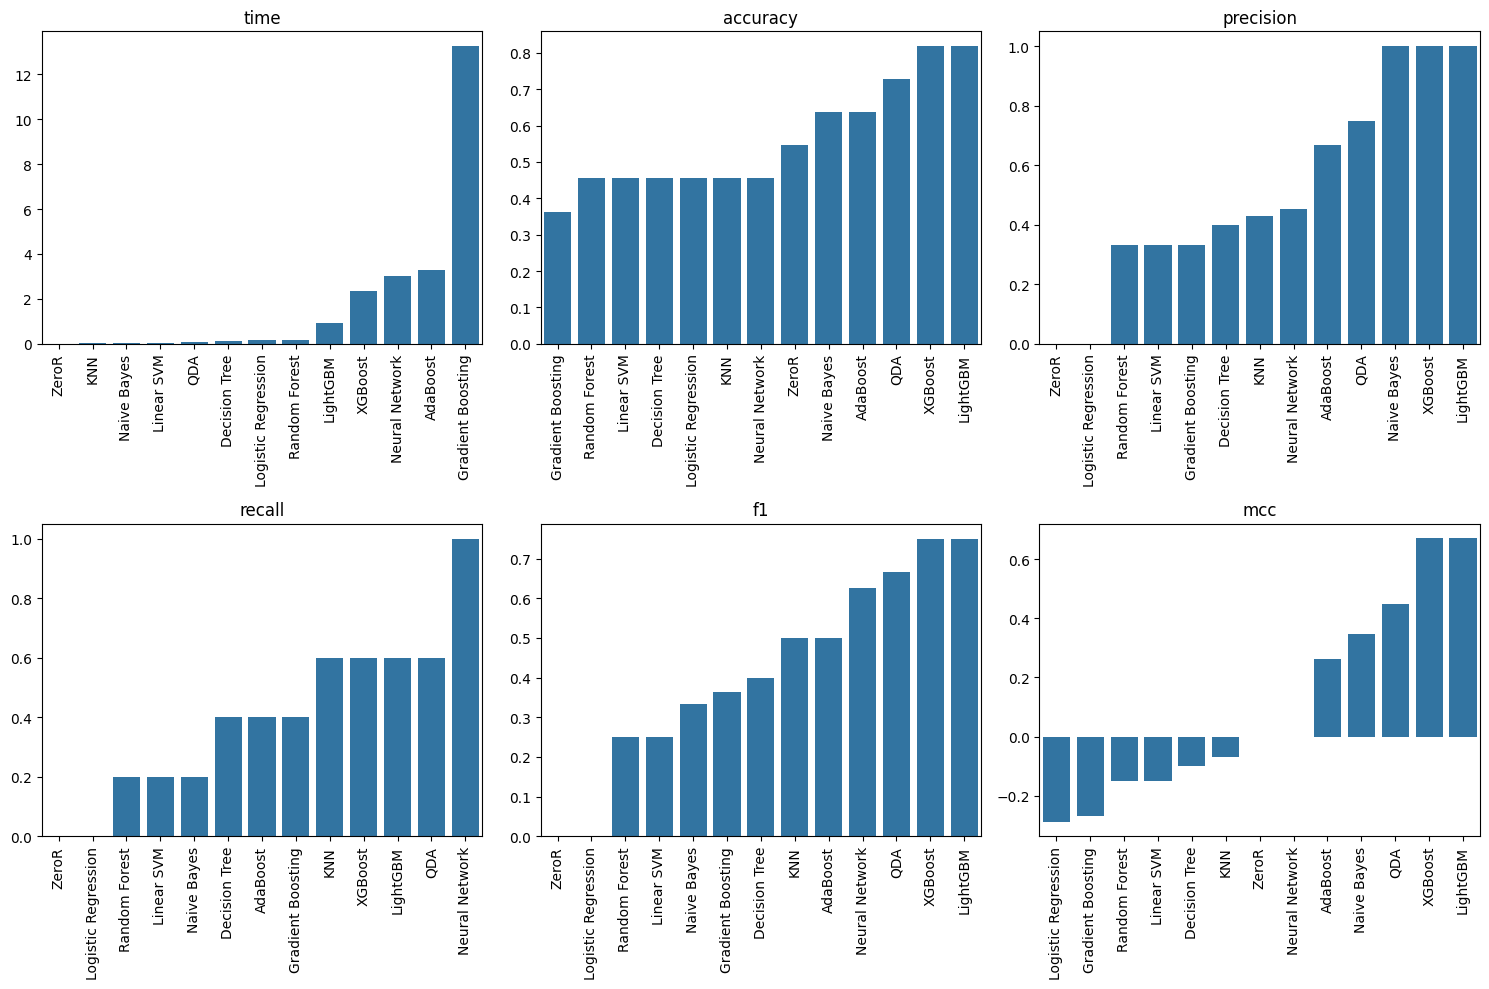

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# List of metrics
metrics = ['time', 'accuracy', 'precision', 'recall', 'f1', 'mcc']
labels = ['Time', 'Scores', 'Scores', 'Scores', 'Scores', 'Scores']

# plot metrics
for i, metric in enumerate(metrics):
    row = i // 3 # integer division to convert i into a row index
    col = i % 3 # modulo division to convert i into a column index
    ax = axs[row, col]
    df_sorted = results_df.sort_values(metric)  # sort by the current metric
    sns.barplot(data=df_sorted, x='name', y=metric, ax=ax) 
    ax.set_xticklabels(df_sorted['name'], rotation=90)  # set x-tick labels to the names in the sorted df
    ax.set_title(metric)
    ax.set_xlabel('')  
    ax.set_ylabel('')  

plt.tight_layout()
plt.show()




#### Plot confusion matrices

In [19]:
print(results_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   13 non-null     object 
 1   time                   13 non-null     float64
 2   accuracy               13 non-null     float64
 3   precision              13 non-null     float64
 4   recall                 13 non-null     float64
 5   f1                     13 non-null     float64
 6   mcc                    13 non-null     float64
 7   confusion_matrix       13 non-null     object 
 8   classification_report  13 non-null     object 
 9   roc_auc                11 non-null     float64
dtypes: float64(7), object(3)
memory usage: 1.1+ KB
None


TypeError: string indices must be integers

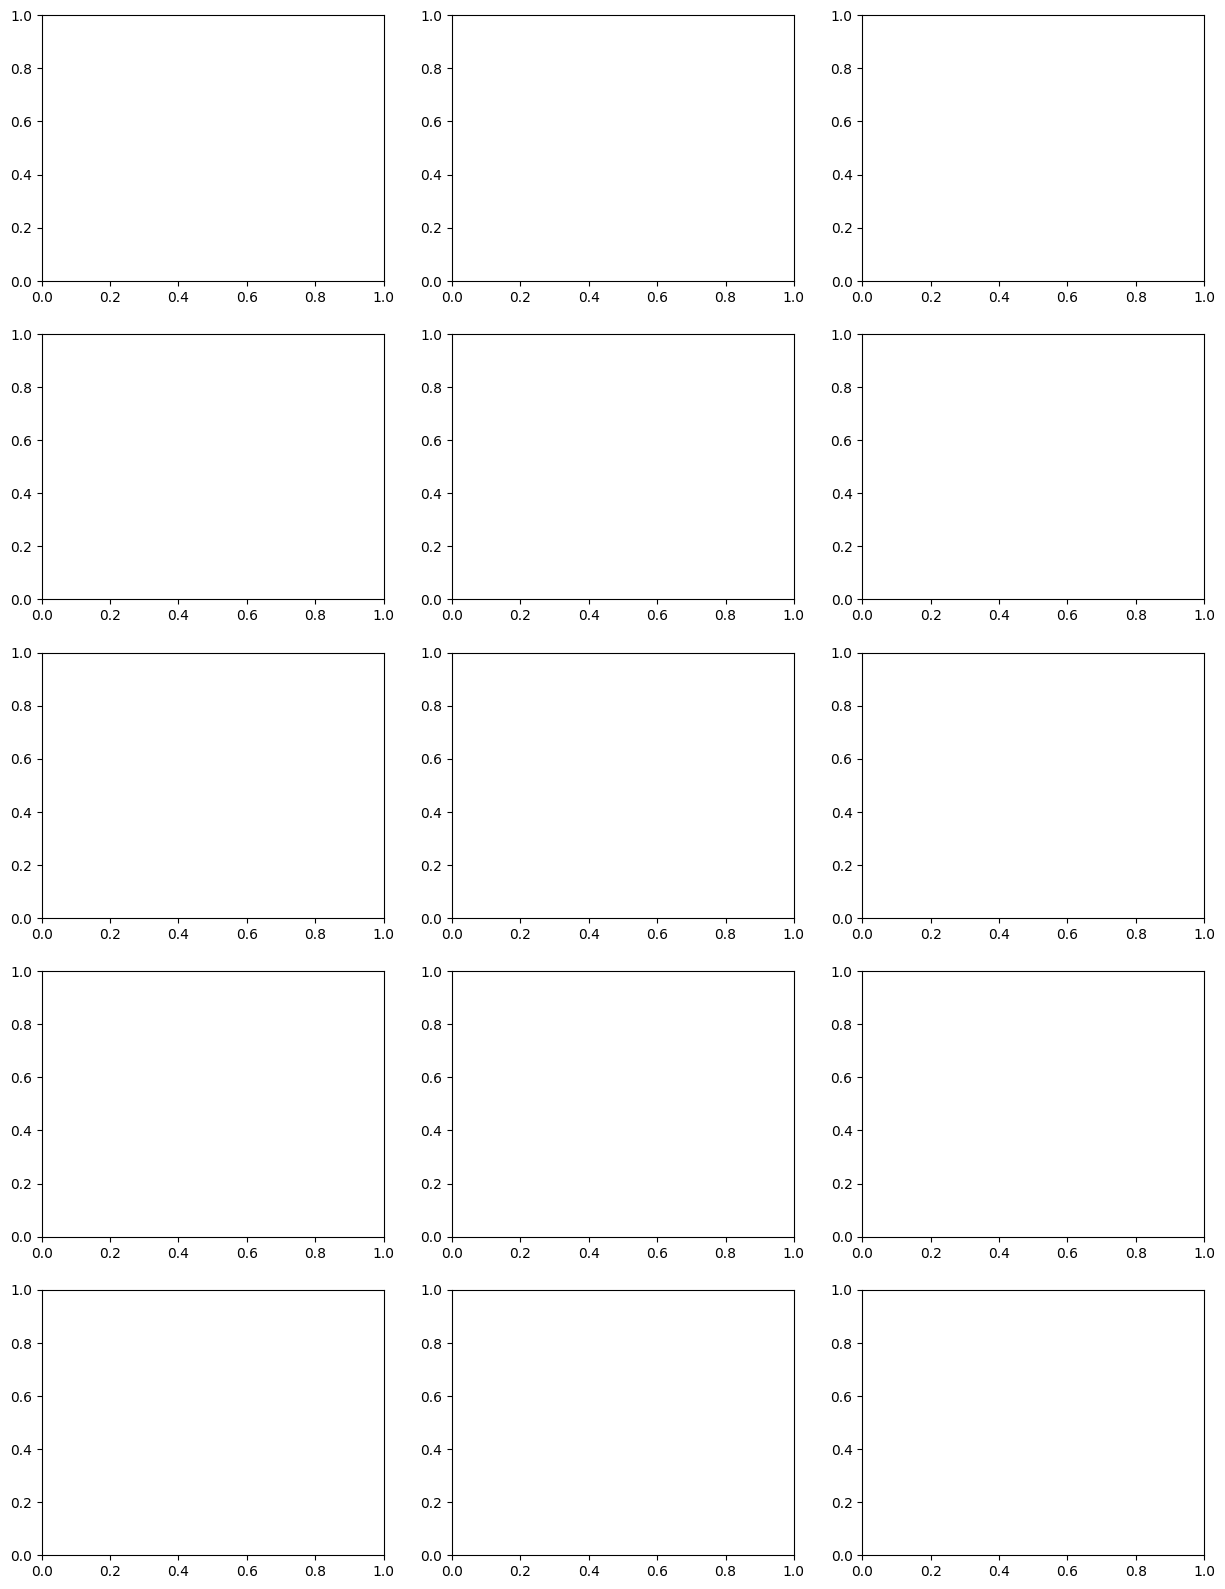

In [20]:
fig, axs = plt.subplots(5, 3, figsize=(15, 20))

# ensure that the number of subplots matches the number of models
#assert len(axs.flatten()) >= len(_df)

# confusion matrix for each model
for i, result in enumerate(results_df):
    ax = axs.flatten()[i]

    name = result['name']
    cm = result['confusion_matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix for {name}')

# hide the extra subplots
for j in range(i+1, len(axs.flatten())):
    axs.flatten()[j].axis('off')

plt.tight_layout()
plt.show()




In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast  # Import the ast module for safe evaluation

# Select the model name for which you want to print the confusion matrix
model_name = "Random Forest"  # Replace with the actual model name from your DataFrame

# Find the corresponding row in the DataFrame
result = results_df[results_df['name'] == model_name].iloc[0]

# Get the confusion matrix string
cm_str = result['confusion_matrix']

# Safely evaluate the confusion matrix string back to a NumPy array
try:
    cm = np.array(ast.literal_eval(cm_str))
except (ValueError, SyntaxError):
    print(f"Error parsing confusion matrix for {model_name}.")
else:
    print(f"Confusion Matrix for {model_name}:\n{cm}")







Error parsing confusion matrix for Random Forest.


### Version 2: Original Resampled to Hourly

In [37]:

# resample  - mean, median, sum
def resample(df, resample_col='activity', frequency='h', save_to_csv=False, output_csv_path=None):
    """
    Resamples a df based on a given timestamp column and aggregates the resampled data.

    Args:
        df (pandas.DataFrame): input df.
        resample_col (str, optional): column to resample. defaults to 'activity'.
        frequency (str, optional): resampling frequency. defaults to 'h'.
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.


    Returns:
        pandas.DataFrame: The resampled and aggregated DataFrame.
    """
    import pandas as pd
    
    # copy df
    df2 = df.copy()
    
    # convert 'timestamp' column to datetime type
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
    
    # convert 'timestamp' column to DatetimeIndex
    df2.set_index('timestamp', inplace=True)
    
    # resample data and calculate mean, sum, and median
    df_resampled = df2.groupby('id')[resample_col].resample(frequency).agg(['mean', 'sum', 'median'])
    
    # reset index
    df_resampled = df_resampled.reset_index()
    
    # add label column
    df_label = df2.groupby(['id', df2.index.date])['label'].first()
    
    # reset index
    df_label = df_label.reset_index()
    
    # rename columns
    df_label.columns = ['id', 'date', 'label']
    
    # convert date to datetime
    df_resampled['date'] = df_resampled['timestamp'].dt.date
    
    # merge dataframes
    df_final = pd.merge(df_resampled, df_label, on=['id', 'date'])

    # change date to datetime
    df_final['date'] = pd.to_datetime(df_final['date'])

    # save to CSV
    if save_to_csv:
        if output_csv_path:
            df_final.to_csv(output_csv_path, index=False)
            print(f"df saved to {output_csv_path}")
        else:
            print("Error: Please provide an output CSV path.")
    
    return df_final

In [38]:
# resample to hourly - garcia_original_scoreNum
garcia_original_scoreNum_resampled = resample(garcia_original_scoreNum, resample_col='activity', frequency='h', save_to_csv=True, output_csv_path='../data/petter/baseline-garcia-original-scoreNum-resampled.csv')

# resample to hourly - garcia_full_scoreNum
garcia_full_scoreNum_resampled = resample(garcia_full_scoreNum, resample_col='activity', frequency='h', save_to_csv=True, output_csv_path='../data/petter/baseline-garcia-full-scoreNum-resampled.csv')

df saved to ../data/petter/baseline-garcia-original-scoreNum-resampled.csv
df saved to ../data/petter/baseline-garcia-full-scoreNum-resampled.csv


In [1]:
import pandas as pd

# Load data from csv
garcia_original_scoreNum_resampled = pd.read_csv('../data/petter/baseline-garcia-original-scoreNum-resampled.csv', parse_dates=['date', 'timestamp'])
garcia_full_scoreNum_resampled = pd.read_csv('../data/petter/baseline-garcia-full-scoreNum-resampled.csv', parse_dates=['date', 'timestamp'])



#### Train / Test Split

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split


# extract relevant features from timestamp
# garcia['day_of_week'] = garcia['timestamp'].dt.dayofweek
# garcia['hour_of_day'] = garcia['timestamp'].dt.hour

# drop unnecessary columns
X = garcia_original_scoreNum_resampled.drop(['timestamp','label', 'date', 'id', 'sum', 'median'], axis=1)
y = garcia_original_scoreNum_resampled['label']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  set the timestamp as the index:
# X_train.set_index('timestamp', inplace=True)
# X_test.set_index('timestamp', inplace=True)


In [3]:
# print nan in x
print(X_train.isna().sum())
print(X_train[X_train.isna().any(axis=1)])

# fill nan with 0
X_train.fillna(0, inplace=True)

# print nan for x test
print(X_test.isna().sum())
print(X_test[X_test.isna().any(axis=1)])

# fill nan with 0
X_test.fillna(0, inplace=True)


mean    3
dtype: int64
       mean
14713   NaN
15987   NaN
15674   NaN
mean    1
dtype: int64
       mean
14400   NaN


#### Import libraries

In [4]:
import time

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


#### Model selection

I have taken the models from the article and added a few additional models for comparison.  

`ZeroR` (Zero Rule) is a simple baseline model which predicts the most frequent class (label).  It has been created as a class below, for inclusion.  

In [5]:
# ZeroR 
class ZeroRClassifier:
    def fit(self, X, y):
        self.majority_class = y.value_counts().idxmax()
    def predict(self, X):
        return [self.majority_class] * len(X)

In [25]:
# full set
models = [
    ('ZeroR', ZeroRClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC(kernel='linear')),
    ('SVM', SVC(kernel='rbf')),
    ('Linear SVM', LinearSVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Gaussian Process', GaussianProcessClassifier())
]


**Model sets**

In [6]:
models_zr = [
    ('ZeroR', ZeroRClassifier())
]

models_rf_dt = [
    ('Random Forest', RandomForestClassifier()),
    ('Decision Tree', DecisionTreeClassifier())
]

models_linear_svc = [
    ('Linear SVM', LinearSVC())
]

models_svm_lin = [
    ('SVM', SVC(kernel='linear'))
]

models_svm_rbf = [
    ('SVM', SVC(kernel='rbf'))
]

models_lr_knn = [
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier())
]

model_nb_nn = [
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier())
]

models_boost = [
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

models_gauss = [
    ('Gaussian Process', GaussianProcessClassifier())
]

models_qda = [
    ('QDA', QuadraticDiscriminantAnalysis())
]

#### Modelling

* `Support Vector Machine (linear)` is very slow -> even on hourly resampled data:

TODO 

* numpy array
* parallelisation
* dimension reduction (PCA)
* 

In [8]:
# zeroR
#results_zr = evaluate_models(models_zr, X_train, y_train, X_test, y_test, print_results=True)

# rf, dt
#results_rf_dt = evaluate_models(models_rf_dt, X_train, y_train, X_test, y_test, print_results=True)

# linear svm
#results_linear_svc = evaluate_models(models_linear_svc, X_train, y_train, X_test, y_test, print_results=True)

# lr, knn
#results_lr_knn = evaluate_models(models_lr_knn, X_train, y_train, X_test, y_test, print_results=True)

# nb, nn
#results_nb_nn = evaluate_models(model_nb_nn, X_train, y_train, X_test, y_test, print_results=True)

# boost
#results_boost = evaluate_models(models_boost, X_train, y_train, X_test, y_test, print_results=True)



# qda
#results_qda = evaluate_models(models_qda, X_train, y_train, X_test, y_test, print_results=True)

# svm lin - NOT COMPLETED (see above)
#results_svm_lin = evaluate_models(models_svm_lin, X_train, y_train, X_test, y_test, print_results=True)

# svm rbf - NOT RUN (see above)
#results_svm_rbf = evaluate_models(models_svm_rbf, X_train, y_train, X_test, y_test, print_results=True)

# gauss - NOT RUN (see above)
#results_gauss = evaluate_models(models_gauss, X_train, y_train, X_test, y_test, print_results=True)


QDA:
Time taken: 0.011889219284057617 seconds
Accuracy: 0.5981981981981982
Precision: 0.5249419953596288
Recall: 0.6355337078651685
F1 Score: 0.5749682337992376
Matthews Correlation Coefficient: 0.20379832782721946
Confusion Matrix: [[1087  819]
 [ 519  905]]
Classification Report:               precision    recall  f1-score   support

           0       0.68      0.57      0.62      1906
           1       0.52      0.64      0.57      1424

    accuracy                           0.60      3330
   macro avg       0.60      0.60      0.60      3330
weighted avg       0.61      0.60      0.60      3330

ROC AUC: 0.6023269214897957





In [9]:
import pickle

# save results to a file
with open('model_qda_results.pkl', 'wb') as file:
    pickle.dump(results_qda, file)

# load results from the file
#with open('model_results.pkl', 'rb') as file:
#    loaded_results = pickle.load(file)


In [ ]:
# Convert DataFrames to NumPy arrays
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# SVM with linear kernel
results_svm_lin = evaluate_models(models_svm_lin, X_train_array, y_train_array, X_test_array, y_test_array, print_results=True)

# SVM with RBF kernel
results_svm_rbf = evaluate_models(models_svm_rbf, X_train_array, y_train_array, X_test_array, y_test_array, print_results=True)

# gauss
results_gauss = evaluate_models(models_gauss, X_train_array, y_train_array, X_test_array, y_test_array, print_results=True)



In [ ]:
# results to dataframe
df_results = pd.DataFrame(results)
#print(df_results.info())

# for each model, print cols 0:7
#print(df_results.iloc[:, 0:7])

#print(df_results.info())

In [ ]:
# print top 3 of each metric
for column_label in df_results.columns[1:7]:
    print(column_label)
    print(df_results.sort_values(by=column_label, ascending=False).head(3)[['name', column_label]])
    print('\n\n')

time
                 name      time
6      Neural Network  0.243849
11  Gradient Boosting  0.194129
0       Random Forest  0.183593



accuracy
                 name  accuracy
0       Random Forest  0.701835
11  Gradient Boosting  0.697248
10                QDA  0.688073



precision
                 name  precision
0       Random Forest   0.622951
11  Gradient Boosting   0.594595
10                QDA   0.590909



recall
             name  recall
6  Neural Network   0.625
5     Naive Bayes   0.600
2   Decision Tree   0.550



f1
                 name        f1
11  Gradient Boosting  0.571429
6      Neural Network  0.558659
5         Naive Bayes  0.558140



mcc
                 name       mcc
11  Gradient Boosting  0.338549
0       Random Forest  0.331047
10                QDA  0.306159





In [ ]:

# extract metrics for class 1 and class 0
class_1_metrics = [results_['precision'] for result in results]  # Example: precision for class 1
class_0_metrics = [result['recall'] for result in results]  # Example: recall for class 0

# calculate weighted average
class_1_samples = len(y_test[y_test == 1])
class_0_samples = len(y_test[y_test == 0])
total_samples = len(y_test)

weighted_avg = (sum(class_1_metrics) * class_1_samples + sum(class_0_metrics) * class_0_samples) / total_samples

print(f'Weighted Average Classification Performance: {weighted_avg}')


### Results - summary - out of the box models: 

* **Accuracy** - proportion of total predictions correct ->    `gradient boost`

$$\frac{{\text{{True Positive}} + \text{{True Negative}}}}{{\text{{Total Prediction}}}}$$

* **Precision**: proportion of positive prediction that are actually correct (Positive Predictive value) -> `neural network`
  
$$\frac{{\text{{True Positive}}}}{{\text{{True Positives}}+ \text{{False Positives}}}}$$

* **Recall**: proportion of actual positives that are correctly identified (aka Sensitivity) -> `Naive Bayes`

$$\frac{{\text{{True Positive}}}}{{\text{{True Positives}} + \text{{False Negatives}}}}$$

* **F1**: harmonic mean of Precision and Recall -> `gradient boost`

$$\frac{{{{2}} * \text{{(Precision}} * \text{{Recall)}}}}{{\text{{Precision}} + \text{{Recall}}}}$$

* **MCC**: measure of quality of binary classifications - considered a balanced measure ->  `gradient boost`

$$\frac{{\text{{(TP * TN - FP *FN)}}}}{{\text{{sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))}}}}$$

* **Quickest**: time ->  `Naive Bayes`



#### Reminder: 

* `True Positives (TP)`:  model predicted positive, and the truth is also positive.
* `True Negatives (TN)`:  model predicted negative, and the truth is also negative.
* `False Positives (FP)`: model predicted positive, and the truth is negative.
* `False Negatives (FN)`: model predicted negative, and the truth is positive.

In [ ]:
# print classification report for eaach model 
for i in range(0, len(df_results)):
    print(df_results['name'][i])
    print(df_results['classification_report'][i])
    print('\n\n')


Random Forest
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       138
           1       0.62      0.47      0.54        80

    accuracy                           0.70       218
   macro avg       0.68      0.65      0.66       218
weighted avg       0.69      0.70      0.69       218




SVM
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       138
           1       0.54      0.51      0.53        80

    accuracy                           0.66       218
   macro avg       0.63      0.63      0.63       218
weighted avg       0.66      0.66      0.66       218




Decision Tree
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       138
           1       0.54      0.55      0.54        80

    accuracy                           0.66       218
   macro avg       0.64      0.64      0.64       218
weighted avg       0.66      0.66   

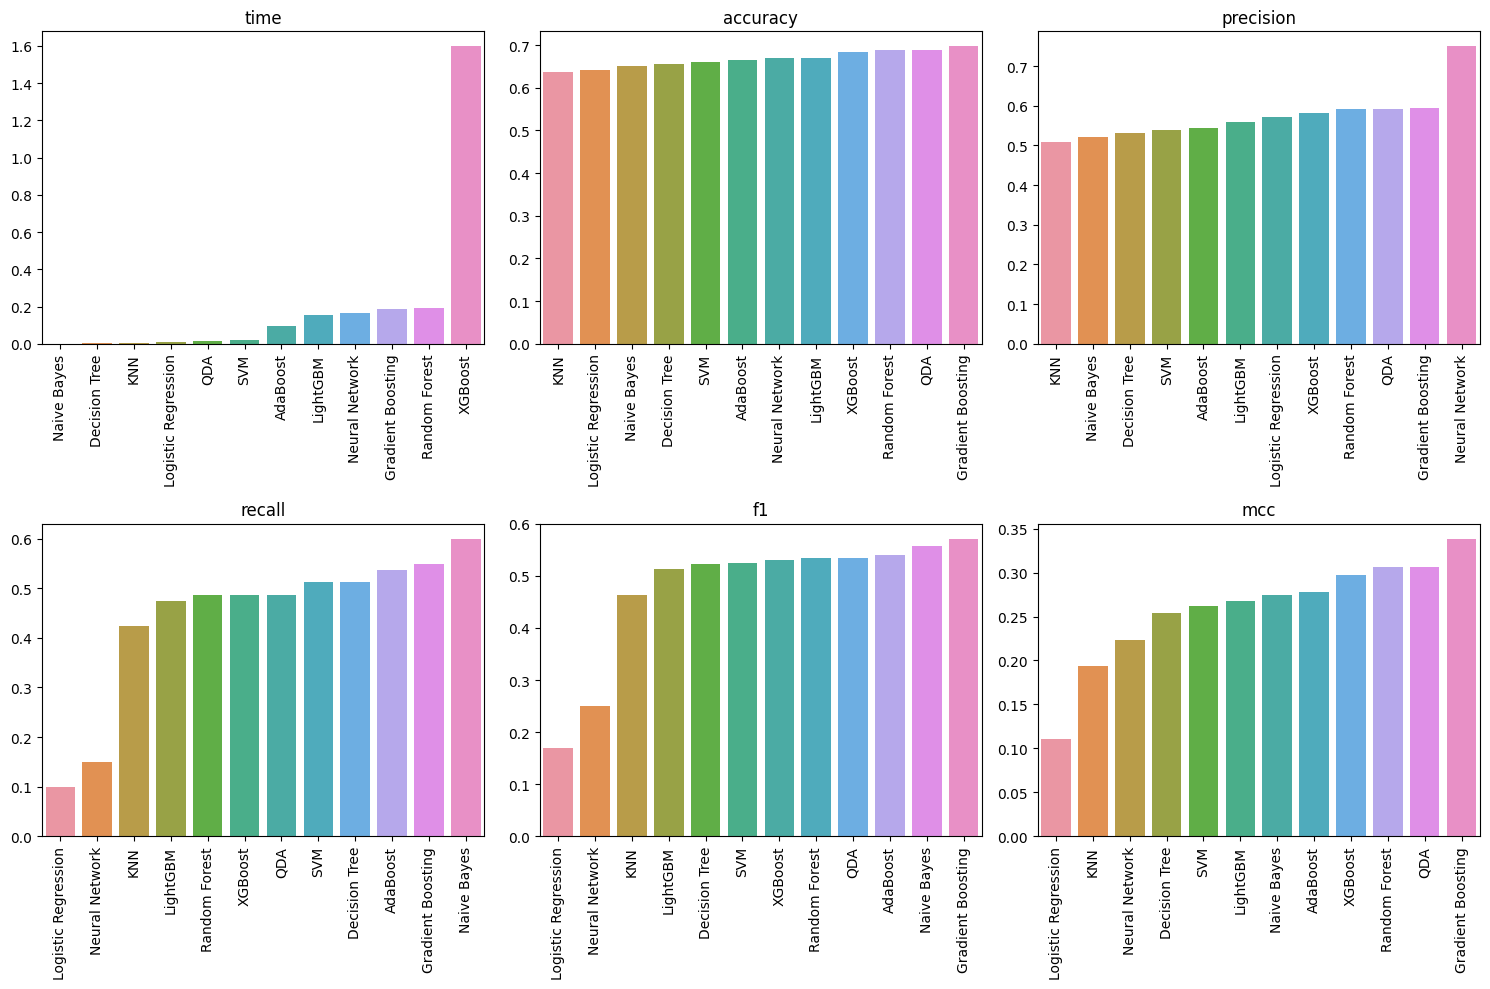

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# List of metrics
metrics = ['time', 'accuracy', 'precision', 'recall', 'f1', 'mcc']
labels = ['Time', 'Scores', 'Scores', 'Scores', 'Scores', 'Scores']

# plot metrics
for i, metric in enumerate(metrics):
    row = i // 3 # Integer division to convert i into a row index
    col = i % 3 # Modulo division to convert i into a column index
    ax = axs[row, col]
    df_sorted = df_results.sort_values(metric)  # sort by the current metric
    sns.barplot(data=df_sorted, x='name', y=metric, ax=ax) 
    ax.set_xticklabels(df_sorted['name'], rotation=90)  # set x-tick labels to the names in the sorted df
    ax.set_title(metric)
    ax.set_xlabel('')  
    ax.set_ylabel('')  

plt.tight_layout()
plt.show()




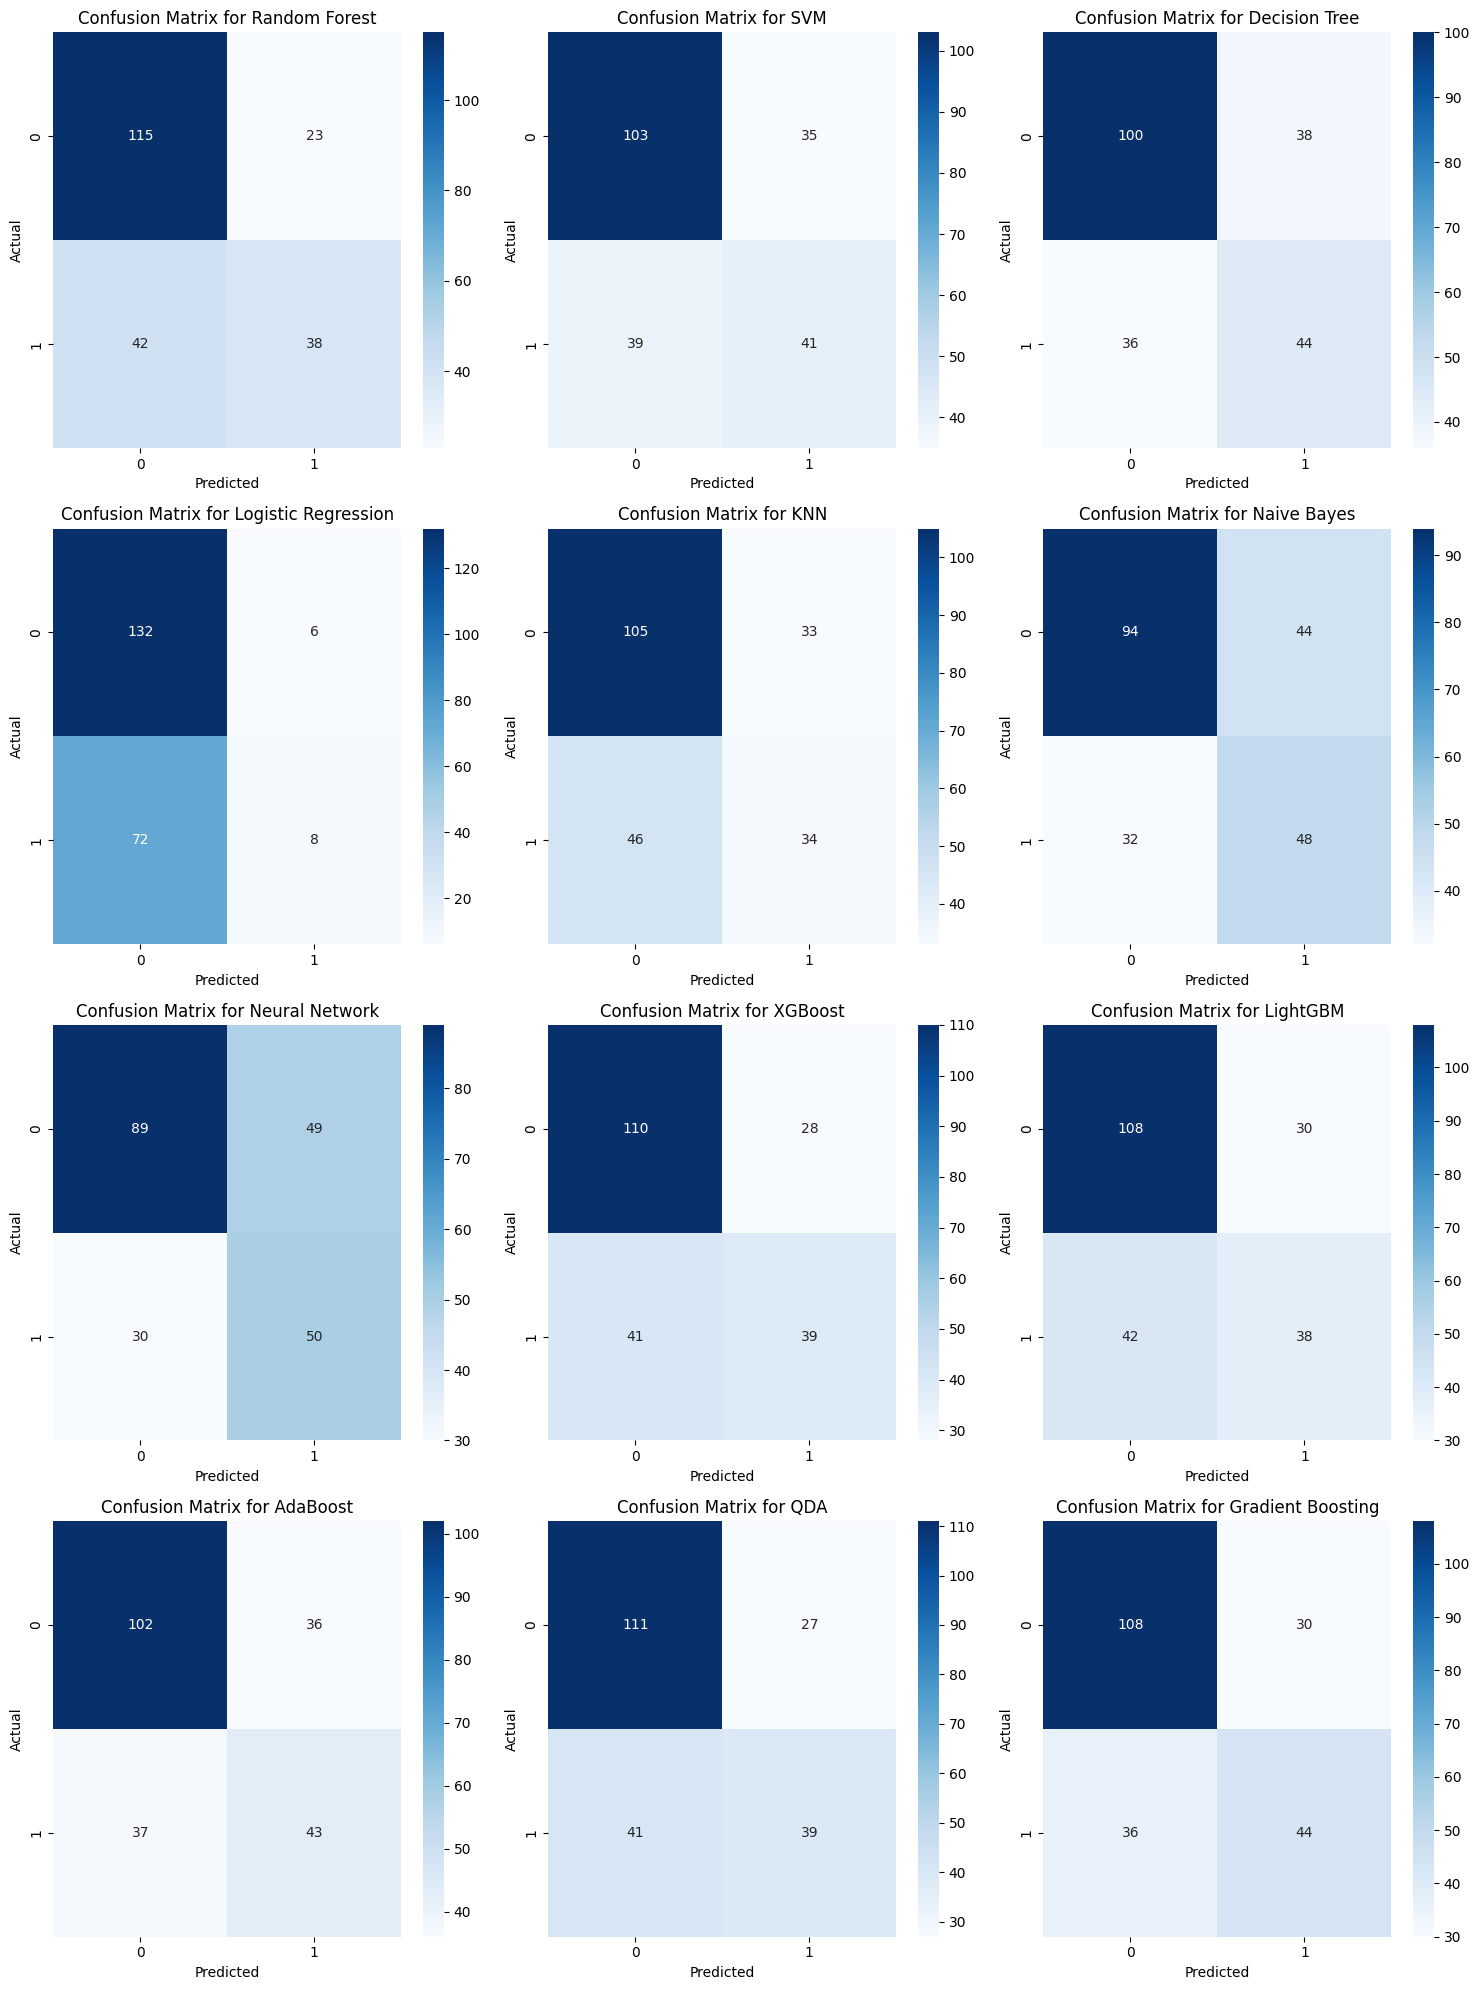

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# ensure that the number of subplots matches the number of models
assert len(axs.flatten()) >= len(results)

# confusion matrix for each model
for i, result in enumerate(results):
    ax = axs.flatten()[i]

    name = result['name']
    cm = result['confusion_matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix for {name}')

# hide the extra subplots
for j in range(i+1, len(axs.flatten())):
    axs.flatten()[j].axis('off')

plt.tight_layout()
plt.show()


